<a href="https://colab.research.google.com/github/INCREDIBLE-AURNOB/Sentiment-analysis/blob/main/Sentiment_analysis_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

In [3]:
dataset='https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

In [4]:

od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alrafiaurnob
Your Kaggle Key: ··········


100%|██████████| 25.7M/25.7M [00:02<00:00, 11.4MB/s]


In [5]:
import os

In [6]:
data_dir='/content/imdb-dataset-of-50k-movie-reviews'
os.listdir(data_dir)

['IMDB Dataset.csv']

In [7]:
import pandas as pd

In [8]:
raw_df=pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
raw_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Preprocessing

In [9]:
import numpy as np
import torch
import torch.nn as nn
import  torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

In [10]:
is_cuda=torch.cuda.is_available()

if is_cuda:
  device=torch.device("cuda")
  print("GPU is available")
else:
  device=torch.device("cpu")
  print("CPU is available")

GPU is available


In [11]:
raw_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Spliting train and test set

In [12]:
x,y=raw_df['review'].values ,raw_df['sentiment']
x[:2],y[:2]

(array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due t

In [13]:

x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)


In [14]:
x_train.shape,x_test.shape

((37500,), (12500,))

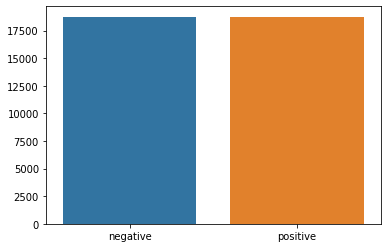

In [15]:
plot=pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=plot.values)
plt.show()

In [16]:
plot=pd.Series(y_train).value_counts(normalize=True)
plot

negative    0.5
positive    0.5
Name: sentiment, dtype: float64

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [19]:
x_train,y_train,x_test,y_test,vocab=tokenize(x_train,y_train,x_test,y_test)

<ipython-input-18-0919ce84a36f>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [20]:
len(vocab)

1000

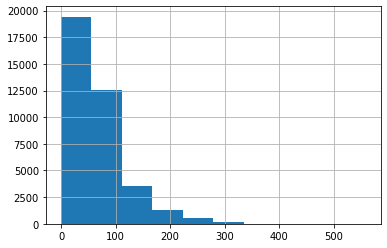

count    37500.000000
mean        69.225307
std         48.111033
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        558.000000
dtype: float64

In [21]:
rev_len=[len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

## Padding
Pad to the max length

In [22]:
def padding_(sentences,seq_length):
  features=np.zeros((len(sentences),seq_length),dtype=int)
  for i,review in enumerate(sentences):
    if len(review)!=0:
      features[i,-len(review):]=np.array(review)[:seq_length]
  return features

In [23]:
x_train_pad=padding_(x_train,500)
x_test_pad=padding_(x_test,500)

Creating tensor dataset

In [24]:
train_data=TensorDataset(torch.from_numpy(x_train_pad),torch.from_numpy(y_train))
valid_data=TensorDataset(torch.from_numpy(x_test_pad),torch.from_numpy(y_test))

#dataloaders
batch_size=50
train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_loader=DataLoader(valid_data,shuffle=True,batch_size=batch_size)

In [25]:
dataiter= iter(train_loader)
sample_x ,sample_y=next(dataiter)


In [26]:
print('Sample input size:',sample_x.size())
print('Sample input: ',sample_x)
print('Sample input : ',sample_y)

Sample input size: torch.Size([50, 500])
Sample input:  tensor([[  0,   0,   0,  ..., 245,   2,  57],
        [  0,   0,   0,  ..., 644,   1, 319],
        [  0,   0,   0,  ..., 682, 157, 328],
        ...,
        [  0,   0,   0,  ..., 762, 360, 816],
        [  0,   0,   0,  ..., 113, 217,  69],
        [  0,   0,   0,  ...,  42, 102, 796]])
Sample input :  tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0])


## Model 

In [40]:
class SentimentRnn(nn.Module):
  def __init__(self,output_dim,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
    super(SentimentRnn,self).__init__()

    self.output_dim=output_dim
    self.hidden_dim=hidden_dim

    self.no_layers=no_layers
    self.vocab_size=vocab_size

    #embedding and LSTM
    self.embedding=nn.Embedding(vocab_size,embedding_dim)

    #lstm
    self.lstm=nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                      num_layers=no_layers,batch_first=True)
    
    #linear and sigmoid layer
    self.fc=nn.Linear(self.hidden_dim,output_dim)
    self.sig=nn.Sigmoid()

    def forward(self,x,hidden):
      batch_size=x.size(0)
      # embeddings and lstm_out
      embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
      #print(embeds.shape)  #[50, 500, 1000]
      lstm_out,hidden=lstm_out.contiguos().view(-1,self.hidden_dim)

      #dropout and fully connected layer
      out=self.dropout(lstm_out)
      out=self.fc(out)

      #sigmoid function
      sig_out=self.sig(out)

      #reshape to batch size first
      sig_out=sig_out[:,-1]  #get last batch of labels

      # returning the last sigmoid output and the hidden state
      return sig_out,hidden


  def init_hidden(self,batch_size):
     # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [41]:
no_layers=2
vocab_size=len(vocab) +1  #extra 1 for padding
embedding_dim=64
output_dim=1
hidden_dim=256

model=SentimentRnn(output_dim,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
model.to(device)
print(model)


SentimentRnn(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training


In [42]:
# loss and optimization

lr=0.01
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

def acc(pred,label):
  pred=torch.round(pred.squeeze())
  return torch.sum(pred==label.squeeze()).item()

In [43]:
len(train_loader.dataset) , len(valid_loader.dataset)

(37500, 12500)

In [44]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

NotImplementedError: ignored